<a href="https://colab.research.google.com/github/lsnjit/project/blob/main/CS_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

schulte_leon_finalproject


April, 21, 2024

#1 Final Project - Data Mining
#### Using Random Forest, KNN and LSTM to predict wether a person has or has not tried Lasagna before

##Goal

The goal of my project is to implement a variety of machine learning classification algorithms (RF and KNN), along with a deep learning model (LSTM), to predict the likelihood of a person having tried Lasagna. This prediction is based on specific diagnostic measurements provided in the dataset.

#2 Library, Data import and function definition


##2.1 Libary import


In [1]:
import os
import numpy as np


import pkg_resources
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer

# import warnings filter
from warnings import simplefilter
# ignore warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import brier_score_loss
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score,roc_curve

##2.2 Function definition

Define the necessary function for model fitting and metric calculation.

In [2]:
def calc_metrics(confusion_matrix):
  TP, FN = confusion_matrix[0][0], confusion_matrix[0][1]
  FP, TN = confusion_matrix[1][0], confusion_matrix[1][1]
  TPR = TP / (TP + FN)
  TNR = TN / (TN + FP)
  FPR = FP / (TN + FP)
  FNR = FN / (TP + FN)
  Precision = TP / (TP + FP)
  F1_measure = 2 * TP / (2 * TP + FP + FN)
  Accuracy = (TP + TN) / (TP + FP + FN + TN)
  Error_rate = (FP + FN) / (TP + FP + FN + TN)
  BACC = (TPR + TNR) / 2
  TSS = TPR - FPR
  HSS = 2 * (TP * TN - FP * FN) / ((TP + FN) * (FN + TN) + (TP + FP) * (FP + TN))
  metrics = [TP, TN, FP, FN, TPR, TNR, FPR, FNR, Precision, F1_measure, Accuracy, Error_rate, BACC, TSS, HSS]
  return metrics

def get_metrics(model, X_train, X_test, Y_train, Y_test, LSTM_flag):
  def calc_metrics(conf_matrix):
    TP, FN = conf_matrix[0][0], conf_matrix[0][1]
    FP, TN = conf_matrix[1][0], conf_matrix[1][1]
    TPR = TP / (TP + FN)
    TNR = TN / (TN + FP)
    FPR = FP / (TN + FP)
    FNR = FN / (TP + FN)
    Precision = TP / (TP + FP)
    F1_measure = 2 * TP / (2 * TP + FP + FN)
    Accuracy = (TP + TN) / (TP + FP + FN + TN)
    Error_rate = (FP + FN) / (TP + FP + FN + TN)
    BACC = (TPR + TNR) / 2
    TSS = TPR - FPR
    HSS = 2 * (TP * TN - FP * FN) / ((TP + FN) * (FN + TN) + (TP + FP) * (FP + TN))
    return [TP, TN, FP, FN, TPR, TNR, FPR, FNR, Precision, F1_measure, Accuracy, Error_rate, BACC, TSS, HSS]

  metrics = []

  if LSTM_flag == 1:
    # Convert data to numpy array
    Xtrain, Xtest, ytrain, ytest = map(np.array, [X_train, X_test, Y_train, Y_test])

    # Reshape data
    shape = Xtrain.shape
    Xtrain_reshaped = Xtrain.reshape(len(Xtrain), shape[1], 1)
    Xtest_reshaped = Xtest.reshape(len(Xtest), shape[1], 1)
    model.fit(Xtrain_reshaped, ytrain, epochs=50,validation_data=(Xtest_reshaped, ytest), verbose=0)
    lstm_scores = model.evaluate(Xtest_reshaped, ytest, verbose=0)
    predict_prob = model.predict(Xtest_reshaped)
    pred_labels = predict_prob > 0.5
    pred_labels_1 = pred_labels.astype(int)
    matrix = confusion_matrix(ytest, pred_labels_1, labels=[1, 0])
    lstm_brier_score = brier_score_loss(ytest, predict_prob)
    lstm_roc_auc = roc_auc_score(ytest, predict_prob)
    metrics.extend(calc_metrics(matrix))
    metrics.extend([lstm_brier_score, lstm_roc_auc, lstm_scores[1]])

  elif LSTM_flag == 0:

    model.fit(X_train, Y_train)
    predicted = model.predict(X_test)
    matrix = confusion_matrix(Y_test, predicted, labels=[1, 0])
    model_brier_score = brier_score_loss(Y_test, model.predict_proba(X_test)[:, 1])
    model_roc_auc = roc_auc_score(Y_test, model.predict_proba(X_test)[:, 1])
    metrics.extend(calc_metrics(matrix))
    metrics.extend([model_brier_score, model_roc_auc, model.score(X_test, Y_test)])

  return metrics

##2.3 Import the data

The file Lasagna Triers-case study.xlsx contains data on 856 people who have either tried or not tried a company's new frozen Lasagna product. The dependent variable, "Have Tried", is categorical. The company believes that "age", "weight", "income" might be useful in discriminating between the two groups.

The data was provided off-line during my bachelor studies, hence I cannot provide a source link. This being said, the data can be downloaded from the following link: https://drive.google.com/uc?export=download&id=1bgQaVVf2CpR0v-wiIdnGnCfuNXteFY5E

For easier use, the data is stored on a google drive and importated automatically.

In [3]:
data_ori = pd.read_csv('https://drive.google.com/uc?export=download&id=1bgQaVVf2CpR0v-wiIdnGnCfuNXteFY5E')

In [4]:
data_ori.head(10)


,Person,Age,Weight,Income,Car_Value,CC_Debt,Mall Trips,Gender,Live_Alone,Dwell_Type,Pay_Type,Nbhd,Have_Tried
0,1,48,175,65500,2190,3510,7,Male,No,Home,Hourly,East,No
1,2,33,202,29100,2110,740,4,Female,No,Condo,Hourly,East,Yes
2,3,51,188,32200,5140,910,1,Male,No,Condo,Salaried,East,No
3,4,56,244,19000,700,1620,3,Female,No,Home,Hourly,West,No
4,5,28,218,81400,26620,600,3,Male,No,Apt,Salaried,West,Yes
5,6,51,173,73000,24520,950,2,Female,No,Condo,Salaried,East,No
6,7,44,182,66400,10130,3500,6,Female,Yes,Condo,Salaried,West,Yes
7,8,29,189,46200,10250,2860,5,Male,No,Condo,Salaried,West,Yes
8,9,28,200,61100,17210,3180,10,Male,No,Condo,Salaried,West,Yes
9,10,29,209,9800,2090,1270,7,Female,Yes,Apt,Salaried,East,Yes


In [5]:
data_ori = data_ori.drop('Person', axis= 1)

In [6]:
data_ori.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856 entries, 0 to 855
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Age         856 non-null    int64 
 1   Weight      856 non-null    int64 
 2   Income      856 non-null    int64 
 3   Car_Value   856 non-null    int64 
 4   CC_Debt     856 non-null    int64 
 5   Mall Trips  856 non-null    int64 
 6   Gender      856 non-null    object
 7   Live_Alone  856 non-null    object
 8   Dwell_Type  856 non-null    object
 9   Pay_Type    856 non-null    object
 10  Nbhd        856 non-null    object
 11  Have_Tried  856 non-null    object
dtypes: int64(6), object(6)
memory usage: 80.4+ KB


No missing values !

#3 Exploratory data analysis

In [7]:
# Feature and label separation
features = data_ori.iloc[:, :-1]
labels = data_ori.iloc[:, -1]

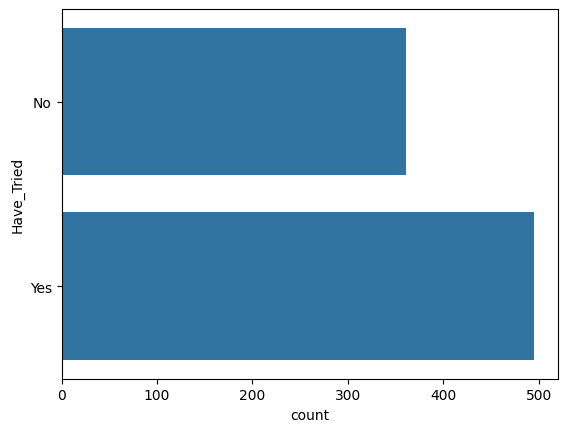

----------Checking for Data Imbalance------------
Number of Positive Outcomes:  495
Percentage of Positive Outcomes: 57.83%
Number of Negative Outcomes :  361
Percentage of Negative Outcomes: 42.17%




In [8]:
# Visualizing the distribution of the target variable
sns.countplot(labels, label="Count")
plt.show()
# Checking for data imbalance
positive_outcomes, negative_outcomes = labels.value_counts()
total_samples = labels.count()
print('----------Checking for Data Imbalance------------')
print('Number of Positive Outcomes: ', positive_outcomes)
print('Percentage of Positive Outcomes: {}%'.format(round((positive_outcomes /total_samples) * 100, 2)))
print('Number of Negative Outcomes : ', negative_outcomes)
print('Percentage of Negative Outcomes: {}%'.format(round((negative_outcomes /total_samples) * 100, 2)))
print('\n')

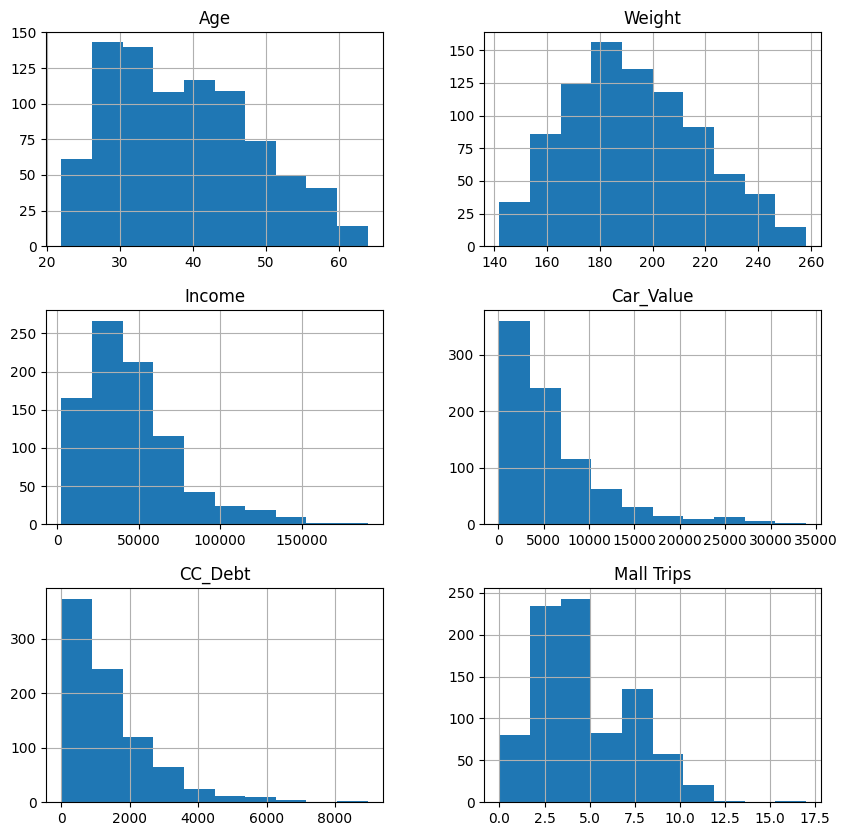

In [9]:
features.hist(figsize=(10, 10))
plt.show()

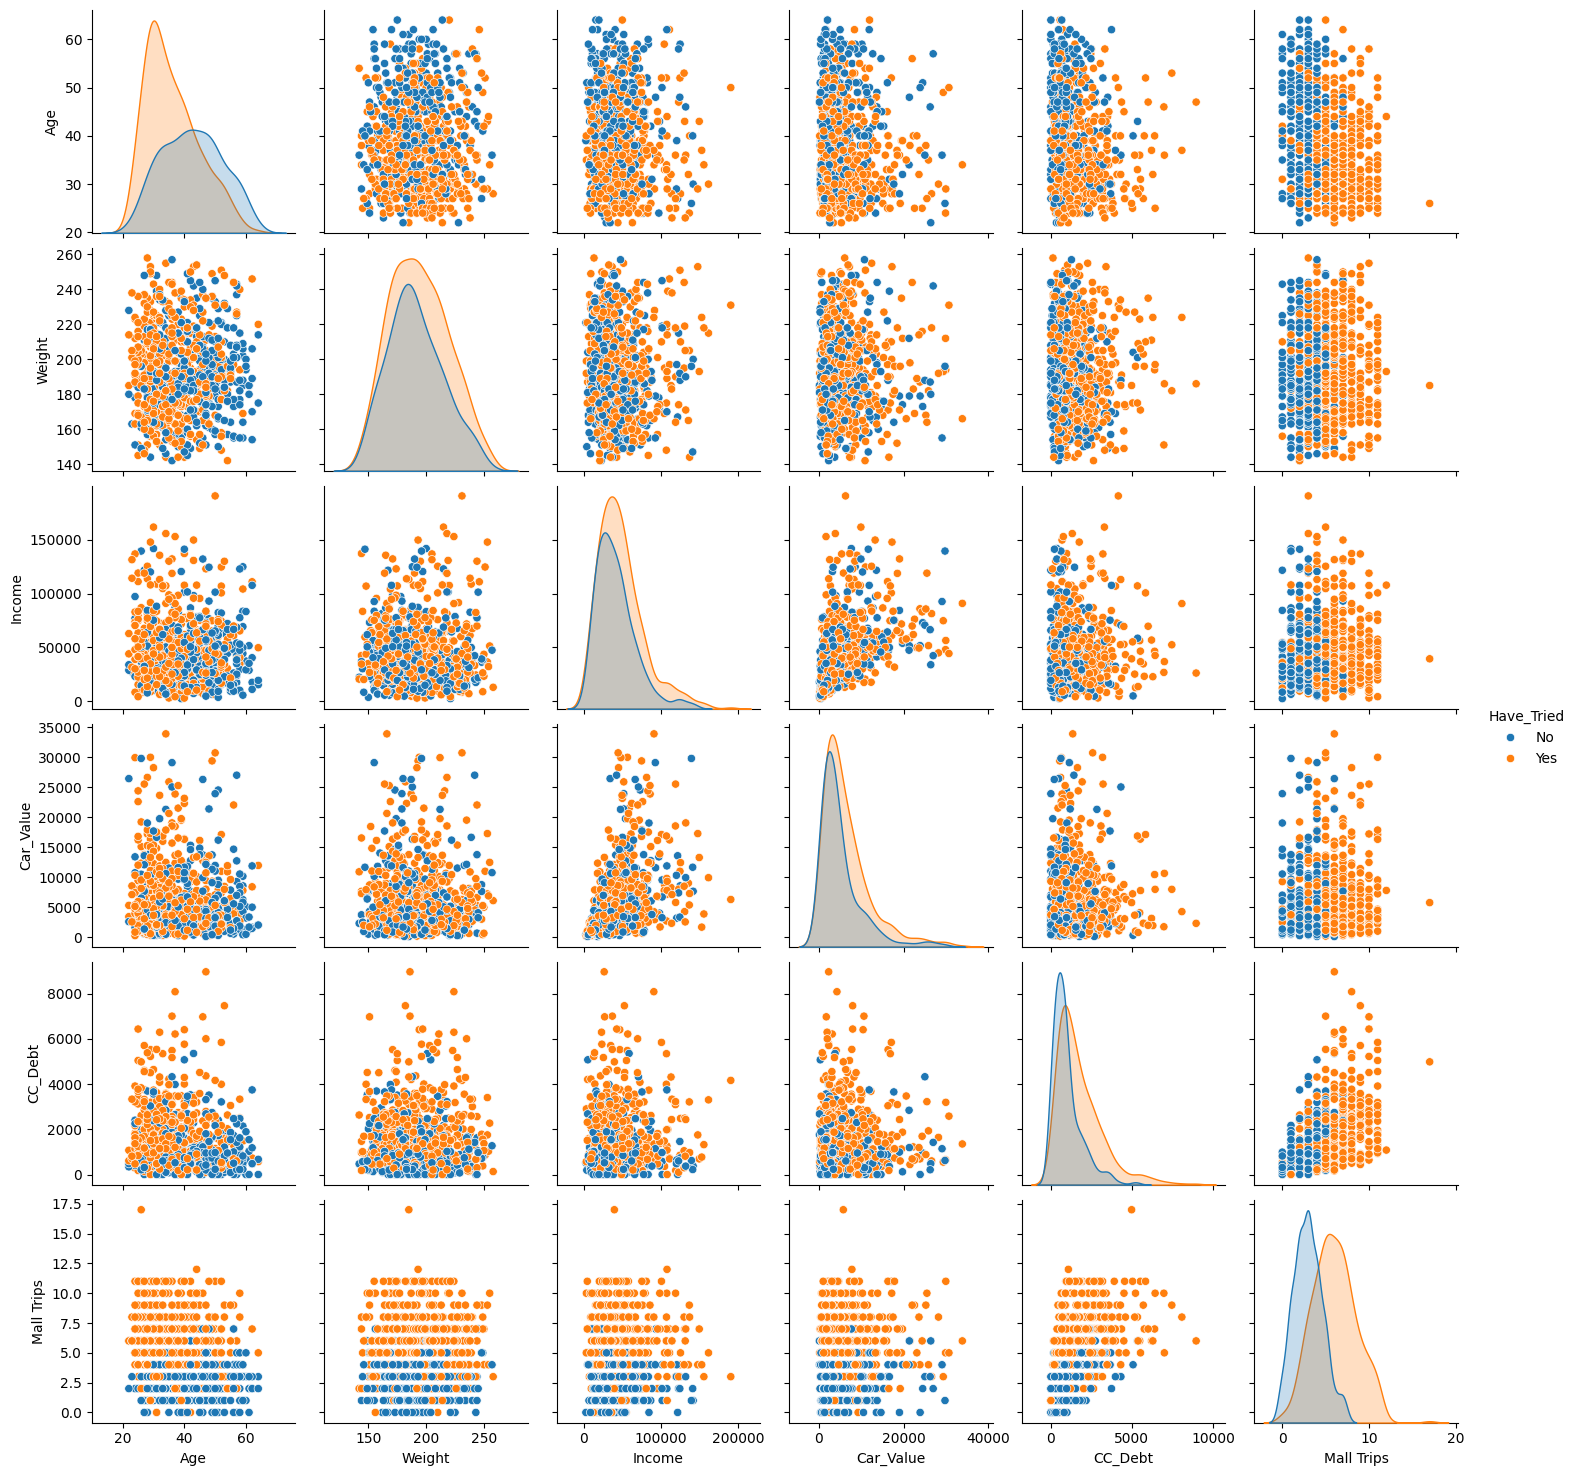

In [10]:
# Creating a pair plot with a hue based on the 'Outcome' column
sns.pairplot(data_ori, hue='Have_Tried')
plt.show()

Upon reviewing the scatter plot matrix, it's noticeable that the frequency of mall visits appears to be a promising feature that could potentially differentiate between individuals who have and have not tried the lasagna. The plots exhibit a discernible separation between the two groups across multiple variables. Such insights could be valuable for a machine learning model aimed at predicting lasagna trial. This distinction is particularly pronounced when examining 'Mall Trips' in relation to other features like 'Income,' 'Car_Value,' and 'CC_Debt,' indicating a potential correlation between shopping habits and the likelihood of trying new products. This observation warrants further statistical analysis to verify its predictive power and to understand the underlying behaviors influencing this trend.

#4 Data preprocessing

First, we keep all the numerical features and add them to a new data frame

In [11]:
data = data_ori.loc[:,['Age', 'Weight', 'Income', 'Car_Value', 'CC_Debt', 'Mall Trips']]

We will now start to convert all non-numerical features

##4.1 Gender

convert to dummy variable

In [12]:
print(data_ori.Gender.value_counts())
data['Gender'] = np.where(data_ori['Gender'] == 'Female', 1,0)

Gender
Male      458
Female    398
Name: count, dtype: int64


##4.2 Live Alone

convert to dummy variable

In [13]:
print(data_ori.Live_Alone.value_counts())
data['Live_Alone'] = np.where(data_ori['Live_Alone'] == 'Yes', 1,0)

Live_Alone
No     711
Yes    145
Name: count, dtype: int64


##4.3 Housing Type

In [14]:
print(data_ori.Dwell_Type.value_counts())
from sklearn.preprocessing import LabelBinarizer
bi_DF = LabelBinarizer()
bi_dummys = bi_DF.fit_transform(data_ori['Dwell_Type'])
bi_dummys.sum(axis=0) # coun't to validate the number

DF_dummys = pd.DataFrame(bi_dummys, columns=['DW_Apt', 'DW_Con', 'DV_Hom']) #transform into data frame; name columns
DF_dummys.head(10)

# drop the first column to avoid the dummy variable trap
DF_dummys = DF_dummys.drop('DW_Apt', axis = 1)
DF_dummys.head(10)

#concat to the end of the data frame; to keep the sequence of the data frame
data = pd.concat([data, DF_dummys], axis=1)

data.head(10)

Dwell_Type
Home     404
Condo    239
Apt      213
Name: count, dtype: int64


,Age,Weight,Income,Car_Value,CC_Debt,Mall Trips,Gender,Live_Alone,DW_Con,DV_Hom
0,48,175,65500,2190,3510,7,0,0,0,1
1,33,202,29100,2110,740,4,1,0,1,0
2,51,188,32200,5140,910,1,0,0,1,0
3,56,244,19000,700,1620,3,1,0,0,1
4,28,218,81400,26620,600,3,0,0,0,0
5,51,173,73000,24520,950,2,1,0,1,0
6,44,182,66400,10130,3500,6,1,1,1,0
7,29,189,46200,10250,2860,5,0,0,1,0
8,28,200,61100,17210,3180,10,0,0,1,0
9,29,209,9800,2090,1270,7,1,1,0,0


##4.4 Pay Type

convert to dummy variable

In [15]:
print(data_ori.Pay_Type.value_counts())
data['Pay_Type'] = np.where(data_ori['Pay_Type'] == 'Hourly', 1,0)


Pay_Type
Salaried    481
Hourly      375
Name: count, dtype: int64


##4.5 Nbhd

In [16]:
print(data_ori.Nbhd.value_counts())
from sklearn.preprocessing import LabelBinarizer
bi_NH = LabelBinarizer()
bi_dummys = bi_NH.fit_transform(data_ori['Nbhd'])
bi_dummys.sum(axis=0) # coun't to validate the number

NH_dummys = pd.DataFrame(bi_dummys, columns=['East', 'South', 'West']) #transform into data frame; name columns
NH_dummys.head(10)

# drop the first column to avoid the dummy variable trap
NH_dummys = NH_dummys.drop('East', axis = 1)
NH_dummys.head(10)

#concat to the end of the data frame; to keep the sequence of the data frame
data = pd.concat([data, DF_dummys], axis=1)

data.head(10)


Nbhd
West     372
East     277
South    207
Name: count, dtype: int64


,Age,Weight,Income,Car_Value,CC_Debt,Mall Trips,Gender,Live_Alone,DW_Con,DV_Hom,Pay_Type,DW_Con,DV_Hom
0,48,175,65500,2190,3510,7,0,0,0,1,1,0,1
1,33,202,29100,2110,740,4,1,0,1,0,1,1,0
2,51,188,32200,5140,910,1,0,0,1,0,0,1,0
3,56,244,19000,700,1620,3,1,0,0,1,1,0,1
4,28,218,81400,26620,600,3,0,0,0,0,0,0,0
5,51,173,73000,24520,950,2,1,0,1,0,0,1,0
6,44,182,66400,10130,3500,6,1,1,1,0,0,1,0
7,29,189,46200,10250,2860,5,0,0,1,0,0,1,0
8,28,200,61100,17210,3180,10,0,0,1,0,0,1,0
9,29,209,9800,2090,1270,7,1,1,0,0,0,0,0


now the dataset is in a well prepared data

##4.6 Target Variable

In [17]:
data['Have_Tried'] = np.where(data_ori['Have_Tried'] == 'Yes', 1,0)

In [18]:
data.head(10)

,Age,Weight,Income,Car_Value,CC_Debt,Mall Trips,Gender,Live_Alone,DW_Con,DV_Hom,Pay_Type,DW_Con,DV_Hom,Have_Tried
0,48,175,65500,2190,3510,7,0,0,0,1,1,0,1,0
1,33,202,29100,2110,740,4,1,0,1,0,1,1,0,1
2,51,188,32200,5140,910,1,0,0,1,0,0,1,0,0
3,56,244,19000,700,1620,3,1,0,0,1,1,0,1,0
4,28,218,81400,26620,600,3,0,0,0,0,0,0,0,1
5,51,173,73000,24520,950,2,1,0,1,0,0,1,0,0
6,44,182,66400,10130,3500,6,1,1,1,0,0,1,0,1
7,29,189,46200,10250,2860,5,0,0,1,0,0,1,0,1
8,28,200,61100,17210,3180,10,0,0,1,0,0,1,0,1
9,29,209,9800,2090,1270,7,1,1,0,0,0,0,0,1


#5 Dataset preperation

##5.1 balance the dataset

Check for data balance

In [19]:
print(data_ori.Have_Tried.value_counts())

# Separate majority and minority classes
data_majority = data[data.Have_Tried==1]
data_minority = data[data.Have_Tried==0]


Have_Tried
Yes    495
No     361
Name: count, dtype: int64


more yes than know, means we have to balance

In [20]:
# Downsample majority class
from sklearn.utils import resample
data_majority_downsampled = resample(data_majority,
                                         replace=False,    # sample without replacement
                                         n_samples=len(data_minority),     # to match minority class
                                         random_state=0) # reproducible results

# Combine minority class with downsampled majority class
data_downsampled = pd.concat([data_majority_downsampled, data_minority])
data_downsampled = data_downsampled.reset_index(drop=True)
print(data_downsampled['Have_Tried'].value_counts())


Have_Tried
1    361
0    361
Name: count, dtype: int64


##5.2 Split the dataset

In [21]:
x = data_downsampled.drop('Have_Tried', axis = 1)
y = data_downsampled['Have_Tried']


##5.3 normalize the dataset

In [22]:
from sklearn import preprocessing
nscaler = preprocessing.MinMaxScaler()
x.iloc[:,:] = nscaler.fit_transform(x.iloc[:,:])

##5.4 Partition the dataset

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(x, y, stratify = y ,test_size=0.5, random_state=0)
print(Y_train.value_counts())
print(Y_test.value_counts())


Have_Tried
1    181
0    180
Name: count, dtype: int64
Have_Tried
0    181
1    180
Name: count, dtype: int64


#6 Algorithm implementation

##6.1 Random Forest

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [25]:
# Define Random Forest parameters for grid search
param_grid_rf = {
    "n_estimators": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    "min_samples_split": [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
}
# Create Random Forest model
rf_classifier = RandomForestClassifier()
# Perform grid search with cross-validation
grid_search_rf = GridSearchCV(estimator=rf_classifier,param_grid=param_grid_rf, cv=10, n_jobs=-1)
grid_search_rf.fit(X_train, Y_train)
# Display the best parameters from the grid search
best_rf_params = grid_search_rf.best_params_
print("\nBest Parameters for Random Forest based on GridSearchCV: ",best_rf_params)
print('\n')
# Extract the best values for 'min_samples_split' and 'n_estimators'
min_samples_split = best_rf_params['min_samples_split']
n_estimators = best_rf_params['n_estimators']


Best Parameters for Random Forest based on GridSearchCV:  {'min_samples_split': 20, 'n_estimators': 90}




##6.2 KNN

In [26]:
from sklearn.neighbors import KNeighborsClassifier


In [27]:
# Define KNN parameters for grid search
knn_parameters = {"n_neighbors": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}
# Create KNN model
knn_model = KNeighborsClassifier()
# Perform grid search with cross-validation
knn_cv = GridSearchCV(knn_model, knn_parameters, cv=10, n_jobs=-1)
knn_cv.fit(X_train, Y_train)
# Print the best parameters found by GridSearchCV
print("\nBest Parameters for KNN based on GridSearchCV: ", knn_cv.best_params_)
print('\n')


Best Parameters for KNN based on GridSearchCV:  {'n_neighbors': 5}




In [28]:
# Extract the best value for 'n_neighbors' from the grid search results
best_n_neighbors = knn_cv.best_params_['n_neighbors']

#7 Results

##7.1 Tabular form

In [29]:
from sklearn.model_selection import StratifiedKFold
cv_stratified = StratifiedKFold(n_splits=10, shuffle=True, random_state=21)

In [30]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [31]:
# Initialize metric columns
metric_columns = ['TP', 'TN', 'FP', 'FN', 'TPR', 'TNR', 'FPR', 'FNR', 'Precision','Brier_score', 'F1_measure', 'Accuracy', 'Error_rate', 'BACC', 'TSS', 'HSS','AUC', 'Acc_by_package_fn']
# Initialize metrics lists for each algorithm
knn_metrics_list, rf_metrics_list, lstm_metrics_list = [],[], []
C = 1.0
# 10 Iterations of 10-fold cross-validation
for iter_num, (train_index, test_index) in enumerate(cv_stratified. split(X_train, Y_train), start=1):
  # KNN Model
  knn_model = KNeighborsClassifier(n_neighbors=best_n_neighbors)
  # Random Forest Model
  rf_model = RandomForestClassifier(min_samples_split=min_samples_split,n_estimators=n_estimators)
  # LSTM model
  lstm_model = Sequential()
  lstm_model.add(LSTM(64, activation='relu', batch_input_shape=(None, 13, 1),return_sequences=False))
  lstm_model.add(Dense(1, activation='sigmoid'))
  # Compile model
  lstm_model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

  # Get metrics for each algorithm
  knn_metrics = get_metrics(knn_model, X_train, X_test, Y_train, Y_test, 0)
  rf_metrics = get_metrics(rf_model, X_train, X_test, Y_train, Y_test, 0)

  lstm_metrics = get_metrics(lstm_model, X_train, X_test, Y_train, Y_test, 1)

  # Append metrics to respective lists
  knn_metrics_list.append(knn_metrics)
  rf_metrics_list.append(rf_metrics)
  lstm_metrics_list.append(lstm_metrics)
  # Create a DataFrame for all metrics
  metrics_all_df = pd.DataFrame([knn_metrics, rf_metrics, lstm_metrics],
                                  columns=metric_columns, index=['KNN', 'RF', 'LSTM'])
    # Display metrics for all algorithms in each iteration
  print('\nIteration {}: \n'.format(iter_num))
  print('\n----- Metrics for all Algorithms in Iteration {} -----\n'. format(iter_num))
  print(metrics_all_df.round(decimals=2).T)
  print('\n')

12/12 [==============================] - 0s 3ms/step

Iteration 1: 


----- Metrics for all Algorithms in Iteration 1 -----

                      KNN      RF    LSTM
TP                 120.00  125.00  113.00
TN                 142.00  157.00  137.00
FP                  39.00   24.00   44.00
FN                  60.00   55.00   67.00
TPR                  0.67    0.69    0.63
TNR                  0.78    0.87    0.76
FPR                  0.22    0.13    0.24
FNR                  0.33    0.31    0.37
Precision            0.75    0.84    0.72
Brier_score          0.71    0.76    0.67
F1_measure           0.73    0.78    0.69
Accuracy             0.27    0.22    0.31
Error_rate           0.73    0.78    0.69
BACC                 0.45    0.56    0.38
TSS                  0.45    0.56    0.38
HSS                  0.21    0.16    0.20
AUC                  0.75    0.86    0.77
Acc_by_package_fn    0.73    0.78    0.69


12/12 [==============================] - 0s 3ms/step

Iteration 2: 


-----

In [32]:
# Initialize metric index for each iteration
metric_index_df = ['iter1', 'iter2', 'iter3', 'iter4', 'iter5', 'iter6','iter7', 'iter8', 'iter9', 'iter10']
# Create DataFrames for each algorithm's metrics
knn_metrics_df = pd.DataFrame(knn_metrics_list, columns=metric_columns,index=metric_index_df)
rf_metrics_df = pd.DataFrame(rf_metrics_list, columns=metric_columns,index=metric_index_df)
lstm_metrics_df = pd.DataFrame(lstm_metrics_list, columns=metric_columns,index=metric_index_df)
# Display metrics for each algorithm in each iteration
for i, metrics_df in enumerate([knn_metrics_df, rf_metrics_df,lstm_metrics_df], start=1):
  print('\nMetrics for Algorithm {}:\n'.format(i))
  print(metrics_df.round(decimals=2).T)
  print('\n')


Metrics for Algorithm 1:

                    iter1   iter2   iter3   iter4   iter5   iter6   iter7  \
TP                 120.00  120.00  120.00  120.00  120.00  120.00  120.00   
TN                 142.00  142.00  142.00  142.00  142.00  142.00  142.00   
FP                  39.00   39.00   39.00   39.00   39.00   39.00   39.00   
FN                  60.00   60.00   60.00   60.00   60.00   60.00   60.00   
TPR                  0.67    0.67    0.67    0.67    0.67    0.67    0.67   
TNR                  0.78    0.78    0.78    0.78    0.78    0.78    0.78   
FPR                  0.22    0.22    0.22    0.22    0.22    0.22    0.22   
FNR                  0.33    0.33    0.33    0.33    0.33    0.33    0.33   
Precision            0.75    0.75    0.75    0.75    0.75    0.75    0.75   
Brier_score          0.71    0.71    0.71    0.71    0.71    0.71    0.71   
F1_measure           0.73    0.73    0.73    0.73    0.73    0.73    0.73   
Accuracy             0.27    0.27    0.27    0.27

In [33]:
# Calculate the average metrics for each algorithm
knn_avg_df = knn_metrics_df.mean()
rf_avg_df = rf_metrics_df.mean()
lstm_avg_df = lstm_metrics_df.mean()
# Create a DataFrame with the average performance for each algorithm
avg_performance_df = pd.DataFrame({'KNN': knn_avg_df, 'RF': rf_avg_df, 'LSTM': lstm_avg_df}, index=metric_columns)
# Display the average performance for each algorithm
print(avg_performance_df.round(decimals=2))
print('\n')

                      KNN      RF    LSTM
TP                 120.00  123.60  115.20
TN                 142.00  156.10  137.10
FP                  39.00   24.90   43.90
FN                  60.00   56.40   64.80
TPR                  0.67    0.69    0.64
TNR                  0.78    0.86    0.76
FPR                  0.22    0.14    0.24
FNR                  0.33    0.31    0.36
Precision            0.75    0.83    0.73
Brier_score          0.71    0.75    0.68
F1_measure           0.73    0.77    0.70
Accuracy             0.27    0.23    0.30
Error_rate           0.73    0.77    0.70
BACC                 0.45    0.55    0.40
TSS                  0.45    0.55    0.40
HSS                  0.21    0.16    0.20
AUC                  0.75    0.86    0.77
Acc_by_package_fn    0.73    0.77    0.70




##7.2 Graphical form

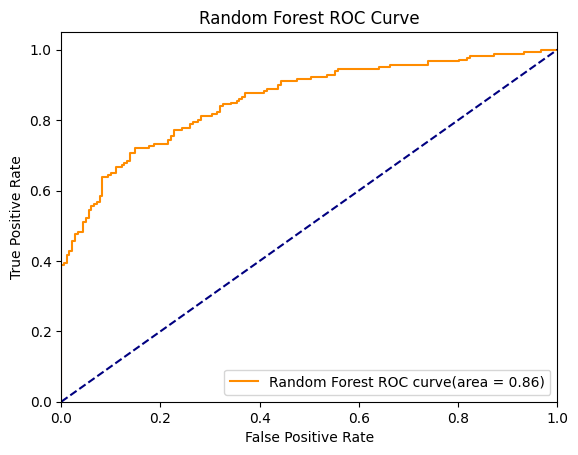

In [34]:
# Random Forest Model
rf_model = RandomForestClassifier(min_samples_split=min_samples_split,n_estimators=n_estimators)
rf_model.fit(X_train, Y_train) # Obtain predicted probabilities
y_score_rf = rf_model.predict_proba(X_test)[:, 1]
# Compute ROC curve and ROC area
fpr_rf, tpr_rf, _ = roc_curve(Y_test, y_score_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
# Plot Random Forest ROC curve
plt.figure()
plt.plot(fpr_rf, tpr_rf, color="darkorange", label="Random Forest ROC curve(area = {:.2f})".format(roc_auc_rf))
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest ROC Curve")
plt.legend(loc="lower right")
plt.show()

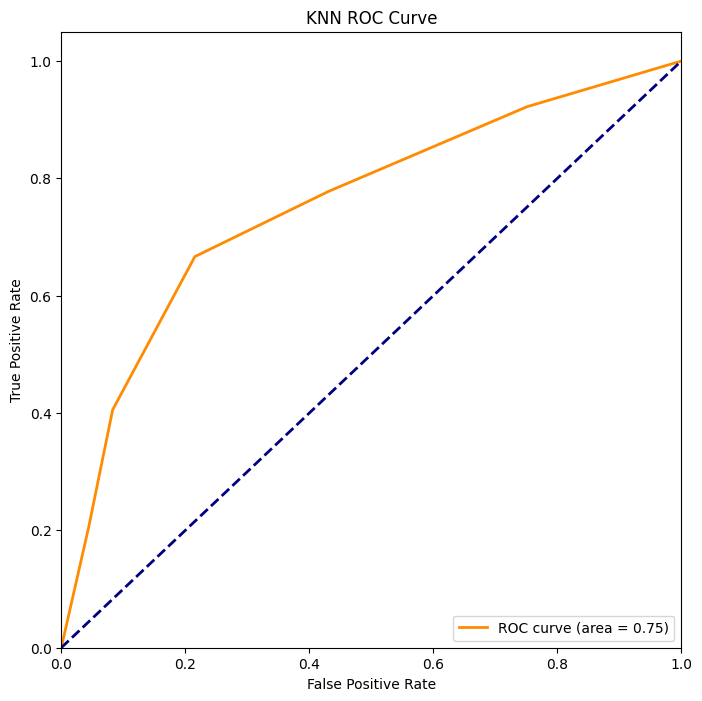

In [35]:
knn_model = KNeighborsClassifier(n_neighbors=best_n_neighbors)
knn_model.fit(X_train, Y_train)

y_score = knn_model.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(Y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN ROC Curve')
plt.legend(loc='lower right')
plt.show()

12/12 [==============================] - 0s 3ms/step


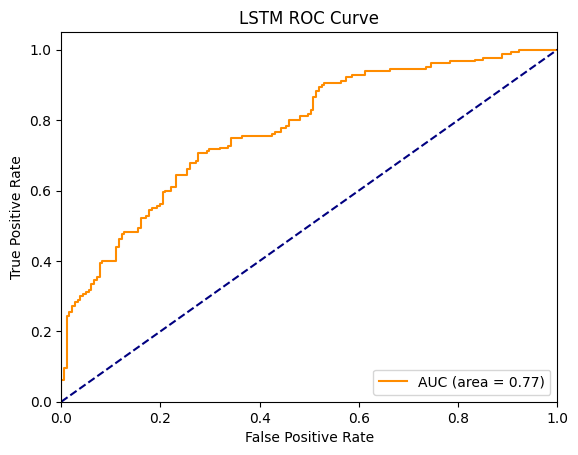

In [36]:
lstm_model = Sequential()
lstm_model.add(LSTM(64, activation='relu', batch_input_shape=(None, 13, 1),return_sequences=False))
lstm_model.add(Dense(1, activation='sigmoid'))


lstm_model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])


X_train_array = X_train.to_numpy()
X_test_array = X_test.to_numpy()
y_train_array = Y_train.to_numpy()
y_test_array = Y_test.to_numpy()


input_shape = X_train_array.shape
input_train = X_train_array.reshape(len(X_train_array), input_shape[1], 1)
input_test = X_test_array.reshape(len(X_test_array), input_shape[1], 1)
output_train = y_train_array
output_test = y_test_array


lstm_model.fit(input_train, output_train, epochs=50,validation_data=(input_test, output_test), verbose=0)


predict_lstm = lstm_model.predict(input_test)


fpr_lstm, tpr_lstm, _ = roc_curve(Y_test, predict_lstm)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)


plt.figure()
plt.plot(fpr_lstm, tpr_lstm, color="darkorange", label="AUC (area = {:.2f})".format(roc_auc_lstm))
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LSTM ROC Curve")
plt.legend(loc="lower right")
plt.show()

#8 Takeaways

Based on the performance metrics presented over ten iterations, the Random Forest (RF) algorithm consistently shows promising results when compared to K-Nearest Neighbors (KNN) and Long Short-Term Memory (LSTM) models. Here’s how we can break down the RF's performance advantages:

True Positives (TP) and True Negatives (TN): RF generally maintains a high number of true positives and true negatives, meaning it correctly identifies the instances that belong to the target class as well as those that do not.

Precision: RF consistently exhibits a high precision, suggesting that when it predicts an instance to be in the positive class, it is correct more often than not. Precision is critical in applications where the cost of false positives is high.

F1 Measure: The F1 measure, which balances the precision and recall (TPR), is generally higher for RF, indicating a more balanced approach to both false positives and false negatives.

Accuracy: While the accuracy appears low for all models, this could be a result of how it's presented here. Accuracy should be in the range of 0 to 1, with 1 being perfect accuracy. It’s likely that the values shown for accuracy are actually the complement (i.e., 1 - accuracy). If this is the case, RF again usually presents higher (true) accuracy compared to the others.

Balanced Accuracy (BACC), True Skill Statistics (TSS), and Heidke Skill Score (HSS): These metrics are more robust than simple accuracy as they take into account the balance between TPR and TNR. RF shows higher values in these metrics as well, indicating its better performance on this dataset.

Area Under the Curve (AUC): The AUC of RF is consistently among the highest, which means that, overall, it has a better measure of separability and a better ability to distinguish between the positive and negative classes.

However, it's important to note that the Long Short-Term Memory (LSTM) network sometimes presents a higher True Positive Rate (TPR) or sensitivity, which suggests that it could be more capable of identifying true positive cases. Yet, its performance is less consistent across other metrics.

The performance of KNN is generally lower than RF, which could be due to its sensitivity to the scale of the data and the curse of dimensionality when dealing with many features.

When assessing model performance, it’s crucial to consider the specific application and cost of different types of errors. If, for instance, the cost of false negatives is very high in a particular application, one might prefer a model with a higher TPR despite other shortcomings.

In summary, based on these iterations, the Random Forest model is the best performer overall for this particular dataset and the metrics provided. This could be due to its ability to handle high dimensional data, its robustness to noise, and its ensemble approach, which combines multiple decision trees to make more accurate and stable predictions.